# Efficiently_Serving_LLMs

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

/home/dongbingcheng/anaconda3/envs/llm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = AutoModelForCausalLM.from_pretrained("models/gpt_2")
tokenizer = AutoTokenizer.from_pretrained("models/gpt_2")

In [9]:
# 查看模型结构 和参数量
print(model)
print(f"{sum( p.numel() for p in  model.parameters())/10e7}M")

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)
1.24439808M


## 文本生成

In [32]:
def generate_toke(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    last_logits = logits[0,-1,:]
    next_token_id = last_logits.argmax()
    return next_token_id

In [33]:
generated_tokens = []
prompt = "The quick brown fox jumped over the"
next_inputs = tokenizer(prompt, return_tensors="pt")
duration_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id = generate_toke(next_inputs)
    duration_s.append(time.time()-t0)

    next_inputs = {
        "input_ids": torch.cat([next_inputs["input_ids"], next_token_id.reshape(-1,1)], dim=1),
        "attention_mask": torch.cat([next_inputs["attention_mask"], torch.tensor([[1]])], dim=1)
    }
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)
print(f"共{sum(duration_s)} s")
print(f"{generated_tokens}")

共0.24642419815063477 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


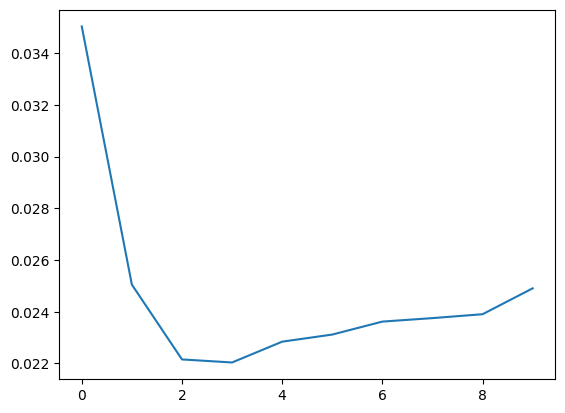

In [34]:
plt.plot(duration_s)
plt.show()

## Speeding up with KV-cache

In [35]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    last_logits = logits[0,-1,:]
    return last_logits.argmax(), outputs.past_key_values

In [36]:
generated_tokens = []
prompt = "The quick brown fox jumped over the"
next_inputs = tokenizer(prompt, return_tensors="pt")
duration_cache_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id, past_key_values = generate_token_with_past(next_inputs)
    duration_cache_s.append(time.time()-t0)

    next_inputs = {
        "input_ids": next_token_id.reshape(1,1),
        "attention_mask": torch.cat([next_inputs["attention_mask"], torch.tensor([[1]])], dim=1),
        "past_key_values": past_key_values,
    }
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)
print(f"共{sum(duration_cache_s)} s")
print(f"{generated_tokens}")

共0.21579575538635254 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


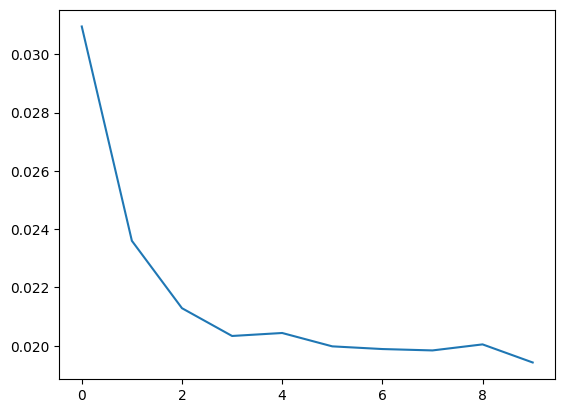

In [38]:
plt.plot(duration_cache_s)
plt.show()

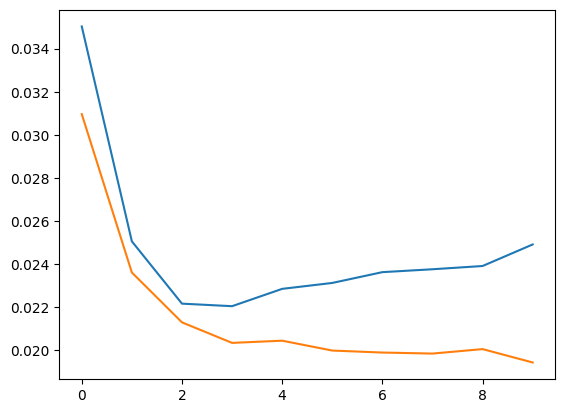

In [41]:
plt.plot(duration_s)
plt.plot(duration_cache_s)
plt.show()
# 可以很明显看到有了KV cache，序列生成并没有因为长度而时间越来越长

## Batching

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.auto import tqdm

In [43]:
model = AutoModelForCausalLM.from_pretrained("models/gpt_2")
tokenizer = AutoTokenizer.from_pretrained("models/gpt_2")

In [52]:
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [44]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    return logits[:,-1,:].argmax(dim=1), outputs.past_key_values

In [53]:
def generate_batch(inputs, max_tokens):
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]
    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) -1  # 返回维度dim的累积和
    position_ids.masked_fill_(attention_mask==0, 1)  # 对padding的位置改为1

    next_inputs = {
        **inputs,
        "position_ids": position_ids
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = generate_batch_tokens_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_ids.reshape((-1,1)),
            "attention_mask": torch.cat([next_inputs["attention_mask"],torch.ones((next_token_ids.shape[0],1))],dim=1),
            "position_ids": next_inputs["position_ids"][:,-1].unsqueeze(-1) + 1,
            "past_key_values": past_key_values
        }
        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    
    return ["".join(tokens) for tokens in generated_tokens]
    
    

In [55]:
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token
# will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")
generated_tokens = generate_batch(inputs, max_tokens=10)
for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence

The rain in Spain falls  on the first day of the month, and the

What comes up must  be a good idea.

"I think



### 吞吐量和延迟

In [59]:
max_tokens = 10

durations = []
throughputs = []
latencies = []
# bs增加吞吐量增大，延迟提高 显卡的每秒计算量有限
batch_sizes = [2**p for p in range(10)]
for batch_size in batch_sizes:
    print(f"bs= {batch_size}")
    t0 = time.time()
    batch_prompts = [
        prompts[i%len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(batch_prompts, padding=True, return_tensors="pt")
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() -t0
    ntokens = batch_size * max_tokens
    throughput = ntokens/duration_s  # 吞吐量为每秒生成的tokens
    avg_latency = duration_s/max_tokens # 平均延迟 每个token延迟的时间
    print("duration", duration_s)
    print("throughput", throughput)
    print("avg latency", avg_latency)    
    print()
    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

bs= 1
duration 0.22410035133361816
throughput 44.62286623153482
avg latency 0.022410035133361816

bs= 2
duration 0.22409868240356445
throughput 89.24639710278763
avg latency 0.022409868240356446

bs= 4
duration 0.22975707054138184
throughput 174.09692727082168
avg latency 0.022975707054138185

bs= 8
duration 0.2635688781738281
throughput 303.52597224031376
avg latency 0.026356887817382813

bs= 16
duration 0.34040045738220215
throughput 470.0346210767624
avg latency 0.03404004573822021

bs= 32
duration 0.4365041255950928
throughput 733.09730936389
avg latency 0.04365041255950928

bs= 64
duration 0.7155253887176514
throughput 894.4476465705762
avg latency 0.07155253887176513

bs= 128
duration 1.3159205913543701
throughput 972.7030706941063
avg latency 0.131592059135437

bs= 256
duration 2.494321823120117
throughput 1026.331075754181
avg latency 0.24943218231201172

bs= 512
duration 5.058351278305054
throughput 1012.1875129470255
avg latency 0.5058351278305053



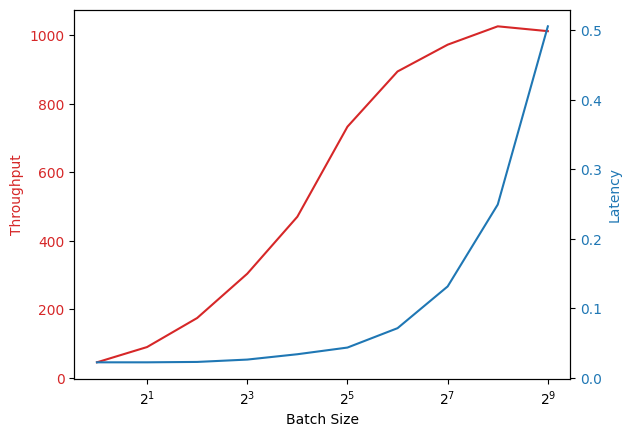

In [60]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax1.set_xscale('log', base=2)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color) 
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)

## Continuous Batching
连续批处理背后的关键思想是不断地将已完成生成的批处理中的请求替换为队列中等待处理的请求。

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

/home/dongbingcheng/anaconda3/envs/llm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_next_inputs(batch, next_token_ids, past_key_values, next_tokens):
    return {
        # '-1' here means the remaining elements for this dim
        "input_ids": next_token_ids.reshape((-1, 1)),
        # increment last, discard the rest
        "position_ids": batch["position_ids"][:, -1].unsqueeze(-1) + 1,
        # concatenate vector of 1's with shape [batch_size]
        "attention_mask": torch.cat([
            batch["attention_mask"],
            torch.ones((next_token_ids.shape[0], 1)),  
        ], dim=1),
        "past_key_values": past_key_values,
        "responses": [
            r1 + r2 for r1, r2 
            in zip(batch["responses"], next_tokens)],
        "tokens_remaining": [
            v - 1 for v in batch["tokens_remaining"]],
    }


def init_batch(requests):
    prompts = [r[0] for r in requests]
    inputs = tokenizer(prompts, padding=True, return_tensors="pt")
    
    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)
    
    return {
        "position_ids": position_ids,
        "responses": copy.copy(prompts),
        "tokens_remaining": [r[1] for r in requests],
        **inputs
    }


def generate_next_token(batch):
    inputs = copy.copy(batch)
    inputs.pop("responses")
    inputs.pop("tokens_remaining")
    
    next_token_ids, past_key_values = \
        generate_batch_tokens_with_past(inputs)
    next_tokens = tokenizer.batch_decode(next_token_ids)
    return get_next_inputs(
        batch, next_token_ids, past_key_values, next_tokens)


def merge_batches(batch1, batch2):
    # first find the max sequence length of the two batches
    # this can be obtained from the second dimension 
    # of the attention mask
    attn_mask1 = batch1["attention_mask"]
    attn_mask2 = batch2["attention_mask"]
    max_seq_len = max(attn_mask1.shape[1], attn_mask2.shape[1])
    
    # pad each mask (on the left) to the max sequence length
    # attention mask uses 0 for padding
    padding1 = max_seq_len - attn_mask1.shape[1]
    padding2 = max_seq_len - attn_mask2.shape[1]
    attn_mask1 = F.pad(attn_mask1, (padding1, 0), "constant", 0)
    attn_mask2 = F.pad(attn_mask2, (padding2, 0), "constant", 0)
    
    # because we only append batches post decoding, 
    # we don't need to pad input_ids
    # or position_ids. these are always length 1 
    # in the sequence dimension
    # however, we do need to pad the 
    # past_key_values, which have shape:
    # [batch_size, num_heads, sequence_length, head_dim]
    past_kv1 = batch1["past_key_values"]
    past_kv2 = batch2["past_key_values"]
    
    padded_kv1 = []
    for i in range(len(past_kv1)):
        k, v = past_kv1[i]
        k = F.pad(k, (0, 0, padding1, 0), "constant", 0)
        v = F.pad(v, (0, 0, padding1, 0), "constant", 0)     
        padded_kv1.append((k, v))
    
    padded_kv2 = []
    for i in range(len(past_kv2)):
        k, v = past_kv2[i]
        k = F.pad(k, (0, 0, padding2, 0), "constant", 0)
        v = F.pad(v, (0, 0, padding2, 0), "constant", 0)     
        padded_kv2.append((k, v))
        
    # now that everything has been padded to have
    # consistent shapes, let's merge
    input_ids = torch.concat(
        [batch1["input_ids"], batch2["input_ids"]], dim=0)
    position_ids = torch.concat(
        [batch1["position_ids"], batch2["position_ids"]], dim=0) 
    attn_mask = torch.concat([attn_mask1, attn_mask2], dim=0)
    
    past_kv = []
    for i in range(len(padded_kv1)):
        k1, v1 = padded_kv1[i]
        k2, v2 = padded_kv2[i]
        k = torch.concat([k1, k2], dim=0)
        v = torch.concat([v1, v2], dim=0)
        past_kv.append((k, v))
    
    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attn_mask,
        "past_key_values": past_kv,
        "responses": batch1["responses"] + batch2["responses"],
        "tokens_remaining": batch1["tokens_remaining"] + batch2["tokens_remaining"],
    }


def filter_batch(batch):
    # mark all rows with 0 tokens remaining for removal
    remove_indices = []
    for i, tokens_remaining in enumerate(batch["tokens_remaining"]):
        if tokens_remaining <= 0:
            remove_indices.append(i)
    
    # first, define a mask used to subselect the indices to keep
    # from each tensor, given the indices to remove
    batch_size = batch["input_ids"].size(0)
    mask = torch.ones(batch_size, dtype=torch.bool)
    mask[remove_indices] = False

    # index into the tensors using the mask to remove rows
    input_ids = batch["input_ids"][mask]
    position_ids = batch["position_ids"][mask]
    attention_mask = batch["attention_mask"][mask]
    responses = [
        r 
        for i, r in enumerate(batch["responses"])
        if i not in remove_indices
    ]
    tokens_remaining = [
        v 
        for i, v in enumerate(batch["tokens_remaining"])
        if i not in remove_indices
    ]

    past_key_values = batch["past_key_values"]
    new_past_key_values = []
    for i in range(len(past_key_values)):
        k, v = past_key_values[i]
        k = k[mask]
        v = v[mask]
        new_past_key_values.append((k, v))
    past_key_values = new_past_key_values
    
    if input_ids.size(0) > 0:
        # next, as an optimization to avoid wasting 
        # compute cycles on padding tokens,
        # we will left truncate the attention_mask 
        # and past_key_values to the longest
        # remaining sequence length
        # we obtain the longest sequence length by 
        # looking for the min first non-zero index
        # of the attention mask
        # cumprod ensures we stop accumulating when we see a 1
        zero_mask = attention_mask == 0
        cumprod = zero_mask.cumprod(dim=1)  
        leading_zeros_count = cumprod.sum(dim=1)
        min_leading_zeros = torch.min(leading_zeros_count)
        truncation_offset = min_leading_zeros.item()

        # do the trunction
        attention_mask = attention_mask[:, truncation_offset:]
        past_key_values = past_key_values
        new_past_key_values = []
        for i in range(len(past_key_values)):
            k, v = past_key_values[i]
            k = k[:, :, truncation_offset:, :]
            v = v[:, :, truncation_offset:, :]
            new_past_key_values.append((k, v))
        past_key_values = new_past_key_values
    
    # return the new batch
    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attention_mask,
        "past_key_values": past_key_values,
        "responses": responses,
        "tokens_remaining": tokens_remaining,
    }, remove_indices


def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values


In [5]:
model_name = "models/gpt_2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)


# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"


# multiple prompts of varying lengths to send to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

In [6]:
attention_mask = inputs["attention_mask"]

In [7]:
zero_mask = attention_mask == 0
zero_mask

tensor([[False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False]])

In [8]:
cumprod = zero_mask.cumprod(dim=1)
cumprod

tensor([[0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0]])

In [9]:
leading_zeros_count = cumprod.sum(dim=1)
leading_zeros_count
# 可以理解为如果从左padding 如果都有左端padding 可以直接给阶段掉

tensor([0, 2, 3])

In [4]:
def generate_batch(inputs, max_tokens):
    generated_tokens = [[] for _ in range(inputs["input_ids"].shape[0])]
    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) -1 
    position_ids.masked_fill_(attention_mask==0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }
    for _ in range(max_tokens):
        next_token_id, past_key_values = generate_batch_tokens_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_id.reshape((-1,1)),
            "attention_mask": torch.cat([next_inputs["attention_mask"], torch.ones((next_token_id.shape[0],1))],dim=1),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "past_key_values": past_key_values
        }
        next_tokens = tokenizer.batch_decode(next_token_id)
        for i, tokens in enumerate(next_tokens):
            generated_tokens[i].append(tokens)
    return ["".join(tokens) for tokens in generated_tokens]

In [59]:
random.seed(42)
queue_size=32
batch_size = 8

request_queue=[
    (prompts[i%len(prompts)],100 if i % batch_size==0 else 10)
    for i in range(queue_size)
]
batches = [
    request_queue[i:i+batch_size]
    for i in range(0, len(request_queue), batch_size)
]

In [60]:
batches[0]

[('The quick brown fox jumped over the', 100),
 ('The rain in Spain falls', 10),
 ('What comes up must', 10),
 ('The quick brown fox jumped over the', 10),
 ('The rain in Spain falls', 10),
 ('What comes up must', 10),
 ('The quick brown fox jumped over the', 10),
 ('The rain in Spain falls', 10)]

In [61]:
# 测试batching 而不是Continuous Batching
t0 = time.time()
with tqdm(total=len(batches), desc=f"bs={batch_size}") as pbar:
    for i, batch in enumerate(batches):
        batch_max_tokens = [b[1] for b  in batch]
        max_tokens = max(batch_max_tokens)
        pbar.set_postfix({"max_tokens": max_tokens})

        batch_prompts = [b[0] for b in batch]
        inputs = tokenizer(batch_prompts, padding=True, return_tensors="pt")
        generate_batch(inputs, max_tokens=max_tokens)
        pbar.update(1)
duration_s = time.time()-t0
print("duration", duration_s)
# 总延迟有10s 而且每次都是2.62s 因为必须解码同一批次seq_len一样长，故而导致了其他生成短的也在batch中，不能释放出来

bs=8: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it, max_tokens=100]

duration 10.495745420455933


In [62]:
## 使用continuous batching
## 使用连续批处理动态地从队列中换入和换出输入。

random.seed(42)
queue_size=32
batch_size = 8

request_queue=[
    (prompts[i%len(prompts)],100 if i % batch_size==0 else 10)
    for i in range(queue_size)
]

In [63]:
t0 = time.time()
with tqdm(total=len(request_queue), desc=f"bs={batch_size}") as pbar:
    batch = init_batch(request_queue[:batch_size])  # 正常处理 将前8个给生成输入 同时多了responses和tokens_remaining
    cached_batch = generate_next_token(batch) # 生成下一个token 并再次构成输入
    request_queue = request_queue[batch_size:]

    while(len(request_queue)>0 or cached_batch["input_ids"].size(0)>0):
        batch_capacity = (
            batch_size - cached_batch["input_ids"].size(0)
        )
        if batch_capacity > 0 and len(request_queue) >0:
            # prefill
            new_batch = init_batch(request_queue[:batch_capacity])
            new_batch = generate_next_token(new_batch)
            request_queue = request_queue[batch_capacity:]
            cached_batch = merge_batches(cached_batch, new_batch) # 融合的时候进行padding 然后拼接
        
        cached_batch = generate_next_token(cached_batch) # 每次都只生成一个token 

        cached_batch, removed_indices = filter_batch(cached_batch)
        pbar.update(len(removed_indices))

duration_s = time.time()-t0
# 时间减少了3倍 大量的消耗在seq_len100上
print(f"time: {duration_s}")

bs=8: 100%|██████████| 32/32 [00:03<00:00,  8.86it/s]

time: 3.612703800201416


## Quantization

In [64]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.models.gpt2.modeling_gpt2 import GPT2Model

In [65]:
def get_next_inputs(batch, next_token_ids, past_key_values, next_tokens):
    return {
        "input_ids": next_token_ids.reshape((-1, 1)),  # '-1' here means the remaining elements for this dim
        "position_ids": batch["position_ids"][:, -1].unsqueeze(-1) + 1,  # increment last, discard the rest
        "attention_mask": torch.cat([
            batch["attention_mask"],
            torch.ones((next_token_ids.shape[0], 1)),  # concatenate vector of 1's with shape [batch_size]
        ], dim=1),
        "past_key_values": past_key_values,
        "responses": [r1 + r2 for r1, r2 in zip(batch["responses"], next_tokens)],
        "tokens_remaining": [v - 1 for v in batch["tokens_remaining"]],
    }


def init_batch(tokenizer, requests):
    prompts = [r[0] for r in requests]
    inputs = tokenizer(prompts, padding=True, return_tensors="pt")
    
    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)
    
    return {
        "position_ids": position_ids,
        "responses": copy.copy(prompts),
        "tokens_remaining": [r[1] for r in requests],
        **inputs
    }


def generate_batch_tokens_with_past(model, inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values


def generate_next_token(model, tokenizer, batch):
    inputs = copy.copy(batch)
    inputs.pop("responses")
    inputs.pop("tokens_remaining")
    
    next_token_ids, past_key_values = generate_batch_tokens_with_past(model, inputs)
    next_tokens = tokenizer.batch_decode(next_token_ids)
    return get_next_inputs(batch, next_token_ids, past_key_values, next_tokens)


def merge_batches(batch1, batch2):
    # first find the max sequence length of the two batches
    # this can be obtained from the second dimension of the attention mask
    attn_mask1 = batch1["attention_mask"]
    attn_mask2 = batch2["attention_mask"]
    max_seq_len = max(attn_mask1.shape[1], attn_mask2.shape[1])
    
    # pad each mask (on the left) to the max sequence length
    # attention mask uses 0 for padding
    padding1 = max_seq_len - attn_mask1.shape[1]
    padding2 = max_seq_len - attn_mask2.shape[1]
    attn_mask1 = F.pad(attn_mask1, (padding1, 0), "constant", 0)
    attn_mask2 = F.pad(attn_mask2, (padding2, 0), "constant", 0)
    
    # because we only append batches post decoding, we don't need to pad input_ids
    # or position_ids. these are always length 1 in the sequence dimension
    # however, we do need to pad the past_key_values, which have shape:
    # [batch_size, num_heads, sequence_length, head_dim]
    past_kv1 = batch1["past_key_values"]
    past_kv2 = batch2["past_key_values"]
    
    padded_kv1 = []
    for i in range(len(past_kv1)):
        k, v = past_kv1[i]
        k = F.pad(k, (0, 0, padding1, 0), "constant", 0)
        v = F.pad(v, (0, 0, padding1, 0), "constant", 0)     
        padded_kv1.append((k, v))
    
    padded_kv2 = []
    for i in range(len(past_kv2)):
        k, v = past_kv2[i]
        k = F.pad(k, (0, 0, padding2, 0), "constant", 0)
        v = F.pad(v, (0, 0, padding2, 0), "constant", 0)     
        padded_kv2.append((k, v))
        
    # now that everything has been padded to have consistent shapes, let's merge
    input_ids = torch.concat([batch1["input_ids"], batch2["input_ids"]], dim=0)
    position_ids = torch.concat([batch1["position_ids"], batch2["position_ids"]], dim=0) 
    attn_mask = torch.concat([attn_mask1, attn_mask2], dim=0)
    
    past_kv = []
    for i in range(len(padded_kv1)):
        k1, v1 = padded_kv1[i]
        k2, v2 = padded_kv2[i]
        k = torch.concat([k1, k2], dim=0)
        v = torch.concat([v1, v2], dim=0)
        past_kv.append((k, v))
    
    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attn_mask,
        "past_key_values": past_kv,
        "responses": batch1["responses"] + batch2["responses"],
        "tokens_remaining": batch1["tokens_remaining"] + batch2["tokens_remaining"],
    }


def filter_batch(batch):
    # mark all rows with 0 tokens remaining for removal
    remove_indices = []
    for i, tokens_remaining in enumerate(batch["tokens_remaining"]):
        if tokens_remaining <= 0:
            remove_indices.append(i)
            
    completed_responses = [
        r 
        for i, r in enumerate(batch["responses"])
        if i in remove_indices
    ]
    
    # first, define a mask used to subselect the indices to keep
    # from each tensor, given the indices to remove
    batch_size = batch["input_ids"].size(0)
    mask = torch.ones(batch_size, dtype=torch.bool)
    mask[remove_indices] = False

    # index into the tensors using the mask to remove rows
    input_ids = batch["input_ids"][mask]
    position_ids = batch["position_ids"][mask]
    attention_mask = batch["attention_mask"][mask]
    responses = [
        r 
        for i, r in enumerate(batch["responses"])
        if i not in remove_indices
    ]
    tokens_remaining = [
        v 
        for i, v in enumerate(batch["tokens_remaining"])
        if i not in remove_indices
    ]

    past_key_values = batch["past_key_values"]
    new_past_key_values = []
    for i in range(len(past_key_values)):
        k, v = past_key_values[i]
        k = k[mask]
        v = v[mask]
        new_past_key_values.append((k, v))
    past_key_values = new_past_key_values
    
    if input_ids.size(0) > 0:
        # next, as an optimization to avoid wasting compute cycles on padding tokens,
        # we will left truncate the attention_mask and past_key_values to the longest
        # remaining sequence length
        # we obtain the longest sequence length by looking for the min first non-zero index
        # of the attention mask
        zero_mask = attention_mask == 0
        cumprod = zero_mask.cumprod(dim=1)  # cumprod ensures we stop accumulating when we see a 1
        leading_zeros_count = cumprod.sum(dim=1)
        min_leading_zeros = torch.min(leading_zeros_count)
        truncation_offset = min_leading_zeros.item()

        # do the trunction
        attention_mask = attention_mask[:, truncation_offset:]
        past_key_values = past_key_values
        new_past_key_values = []
        for i in range(len(past_key_values)):
            k, v = past_key_values[i]
            k = k[:, :, truncation_offset:, :]
            v = v[:, :, truncation_offset:, :]
            new_past_key_values.append((k, v))
        past_key_values = new_past_key_values
    
    # return the new batch
    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attention_mask,
        "past_key_values": past_key_values,
        "responses": responses,
        "tokens_remaining": tokens_remaining,
    }, remove_indices, completed_responses


def generate(model, tokenizer, requests):
    # seed the random number generator so our results are deterministic
    random.seed(42)

    # constants
    batch_size = 8
    request_queue = copy.copy(requests)
    
    responses = [None] * len(requests)

    # and run the initial prefill step
    batch = init_batch(tokenizer, request_queue[:batch_size])
    cached_batch = generate_next_token(model, tokenizer, batch)
    request_queue = request_queue[batch_size:]

    # continue until both the request queue is fully drained and every input
    # within the cached_batch has completed generation
    while len(request_queue) > 0 or cached_batch["input_ids"].size(0) > 0:
        batch_capacity = batch_size - cached_batch["input_ids"].size(0)
        if batch_capacity > 0 and len(request_queue) > 0:
            # prefill
            new_batch = init_batch(tokenizer, request_queue[:batch_capacity])
            new_batch = generate_next_token(model, tokenizer, new_batch)
            request_queue = request_queue[batch_capacity:]

            # merge
            cached_batch = merge_batches(cached_batch, new_batch)

        # decode
        cached_batch = generate_next_token(model, tokenizer, cached_batch)

        # remove any inputs that have finished generation
        cached_batch, removed_indices, completed_responses = filter_batch(cached_batch)

        for idx, resp in zip(removed_indices, completed_responses):
            responses[idx] = resp
    
    return responses

In [103]:
model_name = "models/gpt_2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)


# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [104]:
def get_float32_dtype(self):
    return torch.float32
GPT2Model.dtype = property(get_float32_dtype)

In [105]:
model.get_memory_footprint()

510342192

In [106]:
# 量化
def quantize(t):
    min_val, max_val = t.min(), t.max()
    scale = (max_val-min_val)/255
    zero_point = min_val

    t_quant = (t-zero_point)/scale
    t_quant = torch.clamp(t_quant, min=0, max=255)

    state = (scale, zero_point)
    t_quant = t_quant.type(torch.uint8)
    return t_quant, state

In [107]:
t = model.transformer.h[0].attn.c_attn.weight.data
print(t, t.shape)

tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0525, -0.0113, -0.0156],
        [ 0.0039,  0.0695,  0.3668,  ...,  0.1143,  0.0363, -0.0318],
        ...,
        [-0.2592, -0.0164,  0.1991,  ...,  0.0095, -0.0516,  0.0319],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0293, -0.0429, -0.0475],
        [-0.4100, -0.1924, -0.2400,  ..., -0.0046,  0.0070,  0.0198]]) torch.Size([768, 2304])


In [108]:
t_q,state = quantize(t)
print(t_q, t_q.min(), t_q.max())

tensor([[107, 116, 124,  ..., 130, 125, 129],
        [132, 135, 139,  ..., 126, 128, 127],
        [128, 131, 145,  ..., 133, 130, 127],
        ...,
        [116, 127, 137,  ..., 129, 126, 130],
        [135, 138, 133,  ..., 129, 126, 126],
        [110, 119, 117,  ..., 128, 128, 129]], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


In [109]:
# 反量化
def dequantize(t, state):
    scale, zero_point = state
    return t.to(torch.float32)*scale + zero_point

In [110]:
response_expected = generate(
    model,
    tokenizer,
    [("The quick brown fox jumped over the", 10)]
)[0]
response_expected

'The quick brown fox jumped over the fence and ran to the other side of the fence'

In [111]:
## 量化后生成
def quantize_model(model):
    states = {}
    for name, param in model.named_parameters():
        param.requires_grad = False
        param.data, state = quantize(param)
        states[name] = state
    return model, states

In [112]:
quant_model, states = quantize_model(model)

In [113]:
quant_model.get_memory_footprint() # 占用减少到1/4

137022768

In [117]:
response_expected = generate(
    quant_model,
    tokenizer,
    [("The quick brown fox jumped over the", 10)]
)[0]
response_expected  # 量化之后生成就不太行

'The quick brown fox jumped over the fence.\n\nThe fox jumped over the fence'

In [114]:
def dequantize_model(model, states):
    for name, param in model.named_parameters():
        state = states[name]
        param.data = dequantize(param.data, state)
    return model

In [115]:
dequant_model = dequantize_model(quant_model, states)
dequant_model.get_memory_footprint()

510342192

In [116]:
response_expected = generate(
    dequant_model,
    tokenizer,
    [("The quick brown fox jumped over the", 10)]
)[0]
response_expected  # 量化之后生成可以接受

'The quick brown fox jumped over the fence.\n\nThe fox jumped over the fence'